## Processing an Image to Detect Boats
Illustration of code used in "Detector.py" to extract boats from a frame image

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
basename="20170818-110708-8767"
fmaskedimage = 'C:/ForClassification/Images/maskedimage-{}.jpg'.format(basename)
frawimage = 'C:/ForClassification/Images/raw-{}.jpg'.format(basename)
maskedimage = cv2.imread(fmaskedimage,0)
rawimage = cv2.imread(frawimage,0)
crawimage = cv2.imread(frawimage)

For each frame, there are three images:

* MakedImage: a mask highlighting areas representing movement from the last frame
* RawImage: a monochrome image of the frame
* CRawImage: A colour image of the frame

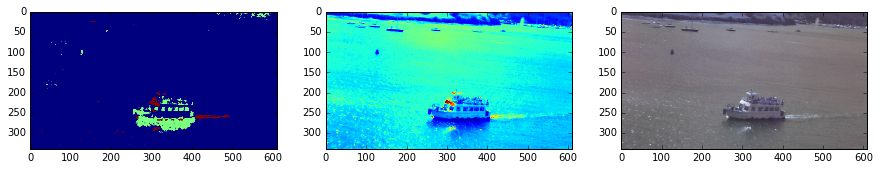

In [3]:
fig=plt.figure()
a=fig.add_subplot(1,3,1)
plt.imshow(maskedimage)
a=fig.add_subplot(1,3,2)
plt.imshow(rawimage)
a=fig.add_subplot(1,3,3)
plt.imshow(crawimage)
plt.show()

Take the masked image and using threshold, find the edges for movement areas. Display "im_bw" which shows the areas representing movement

In [4]:
(thresh, im_bw) = cv2.threshold(maskedimage, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

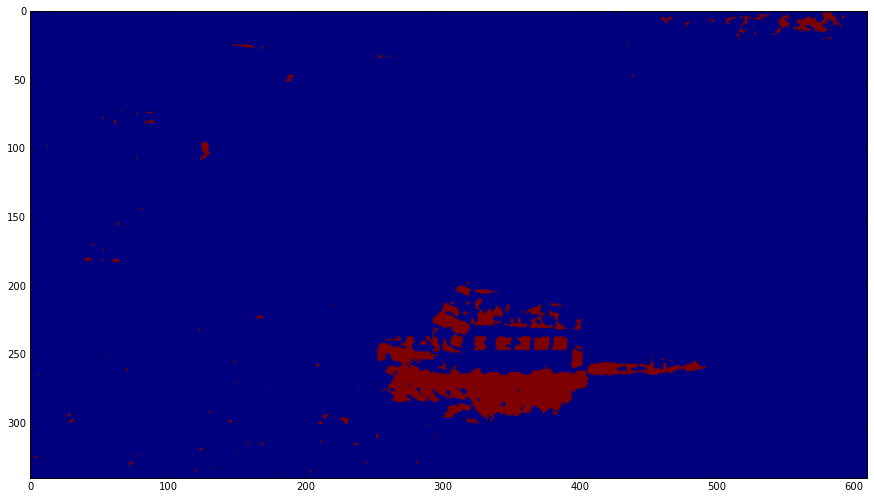

In [5]:
plt.imshow(im_bw)

In [6]:
class Point:
    def __init__(self, xcoord=0, ycoord=0):
        self.x = xcoord
        self.y = ycoord
    
    def dist(self, other):
        return math.hypot(abs(other.x - self.x), abs(other.y- self.y))

    def __str__(self):
        return "Point: x:{} y:{}".format(self.x,self.y)
        
class Rectangle:
    def __init__(self, top_left, bottom_right):
        self.top_left = top_left
        self.bottom_right = bottom_right

    def intersects_x(self, other):
        return (self.top_left.x <= other.bottom_right.x) and (other.top_left.x <= self.bottom_right.x)
    
    def intersects_y(self, other):
        return (self.top_left.y <= other.bottom_right.y) and (other.top_left.y <= self.bottom_right.y)
        
    def contains(self, other):
        return self.top_left.x < other.top_left.x < other.bottom_right.x < self.bottom_right.x and \
                    self.top_left.y < other.top_left.y < other.bottom_right.y < self.bottom_right.y
        
    def adjacent(self, other):
        adjacent_x =  (abs(self.top_left.x - other.bottom_right.x) <= 1 or \
               abs(self.bottom_right.x - other.top_left.x) <= 1) and self.intersects_y(other)
        adjacent_y = (abs(self.top_left.y - other.bottom_right.y) <= 1 or \
               abs(self.bottom_right.y - other.top_left.y) <= 1) and self.intersects_x(other)
        return adjacent_x or adjacent_y
                
    def merge(self, other):
        tl = Point(min(self.top_left.x, other.top_left.x), min(self.top_left.y, other.top_left.y))
        br = Point(max(self.bottom_right.x, other.bottom_right.x), max(self.bottom_right.y, other.bottom_right.y))
        return Rectangle(tl, br)
    
    def __str__(self):
        return "Rectangle: top_left: {} bottom_right: {} ".format(self.top_left, self.bottom_right)

Find contours for the movement areas, and remove the smallest contours (which are typically noise). We are left with 42 contours of interest from the original 179.

In [7]:
im2, contours, hierarchy = cv2.findContours(im_bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print("Number contours:", len(contours))

Number contours: 179


In [8]:
#http://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
smallestcontour = 5
newcontours = []
for c in contours:
    area = cv2.contourArea(c)
    if area > smallestcontour:
        newcontours.append(c)
contours = newcontours
print("Number of contours:", len(contours))

Number of contours: 42


Superimpose the contours onto the original colour image for illustration

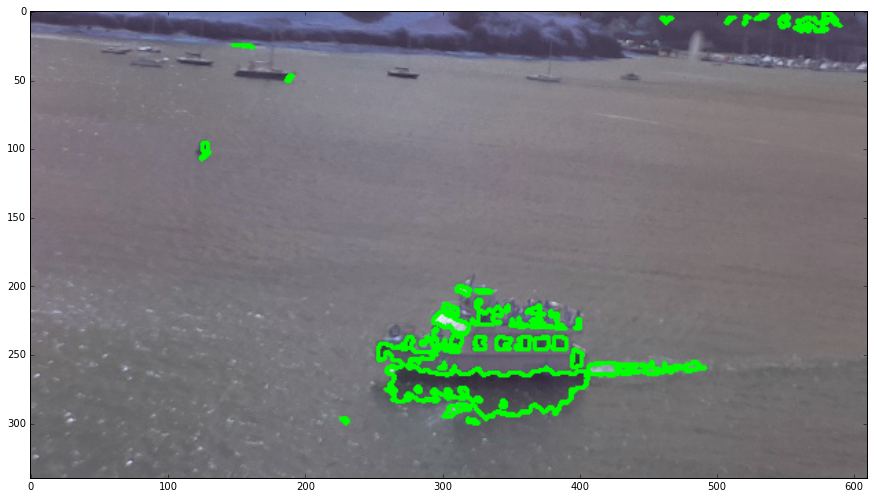

In [9]:
crawimage = cv2.imread(frawimage)
cv2.drawContours(crawimage,contours,-1,(0,255,0),2)
plt.imshow(crawimage)

Now merge contours that close to one another to reduce the number of contours. In this case the number of contours is reduced from 42 to 11.

In [10]:
mindist = 1
minradius = 0

def buildcontourlist(contours):
    contourlist = []
    for c in contours:
        center, radius = cv2.minEnclosingCircle(c)
        contourlist.append((c, center, radius))
    return contourlist

def getfirstcandidate(contourlist):
    for i in range(len(contourlist)):
        ith = contourlist[i]
        for j in range(i+1, len(contourlist)):
            jth = contourlist[j]
            # distance between two centers
            d = math.hypot(abs(ith[1][0] - jth[1][0]), abs(ith[1][1]- jth[1][1]))
            # subtract sum of two radii
            d -= (ith[2] + jth[2])
            if d < mindist:
                return (int(round(d)), i, j)
    return (mindist + 1, 0, 0)

def mergecontours(ith, jth, contours, contourlist):
    cont = np.vstack(contours[i] for i in [ith, jth])
    merged = cv2.convexHull(cont)
    contours = [c for i, c in enumerate(contours) if i not in [ith, jth]]
    contourlist = [c for i, c in enumerate(contourlist) if i not in [ith, jth]]
    contours.append(merged)
    center, radius = cv2.minEnclosingCircle(merged)
    contourlist.append((merged, center, radius))
    return (contours, contourlist)

print("Before ", len(contours))
t0 = time.time()
contourlist = buildcontourlist(contours)
t0 = time.time()
while True:
    t0 = time.time()
    d, ith, jth = getfirstcandidate(contourlist)
    t1 = time.time()
    if d > mindist:
        break
    contours, contourlist = mergecontours(ith, jth, contours, contourlist)
    
print("After ", len(contours))
unified = contours

Before  42
After  11


Now display the merged contours on superimposed on the colour map

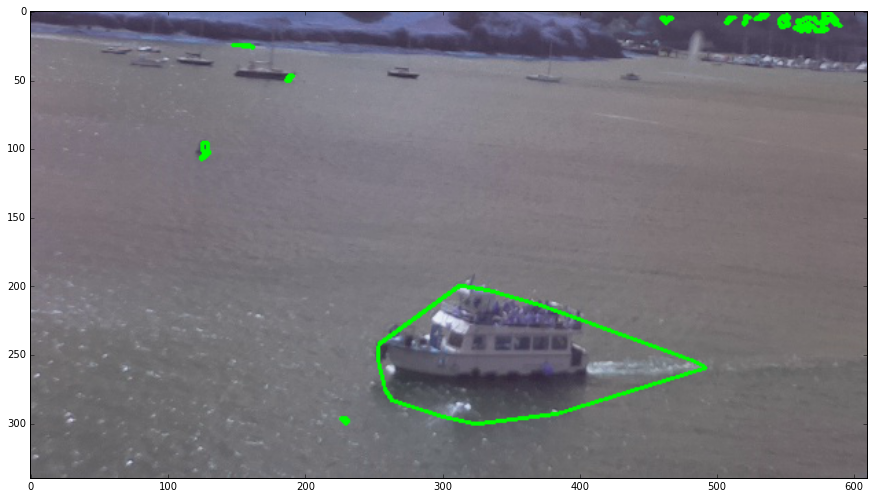

In [11]:
crawimage = cv2.imread(frawimage)
_ = cv2.drawContours(crawimage,contours,-1,(0,255,0),2)
plt.imshow(crawimage)

Remove contours that are contained within other contours. This does not happen very frequently, but improves boat detection. Then, find the bounding rectangles for each of the remaining contours

In [12]:
# see if a contour is  contained in another
toremove=[]
for i, c1 in enumerate(unified):
    for j, c2 in enumerate(unified):
        if i != j:
            m2 = cv2.moments(c2)
            cX = int(m2["m10"] / m2["m00"])
            cY = int(m2["m01"] / m2["m00"])
            if cv2.pointPolygonTest(c1, (cX, cY), False) > 0:
                toremove.append(j)
toremove=set(toremove)
unified = [c for i, c in enumerate(unified) if i not in toremove ]

# remove contours whose bounding rectangle is in another contour's bounding rectangle
rectangles=[]
for i, c in enumerate(unified):
    x, y, w,h = cv2.boundingRect(c)
    rectangles.append(Rectangle(Point(x, y), Point(x + w, y + h)))
    
toremove=[]
for i, r1 in enumerate(rectangles):
    for j, r2 in enumerate(rectangles):
        if i != j:
            if r1.contains(r2):
                toremove.append(j)
toremove=set(toremove)
unified = [c for i, c in enumerate(unified) if i not in toremove]
rectangles = [r for i, r in enumerate(rectangles) if i not in toremove] 
#contained rectangles removed 

Sometimes, bounding rectangles are adjacent or overlapping. This merges such rectangles

In [13]:
# merge adjacent bounding rectangles

def mergerectangles(rects):
    for i, r1 in enumerate(rects):
        for j, r2 in enumerate(rects):
            if i != j and r1.adjacent(r2):
                rects = [r for rn, r in enumerate(rects) if rn != i and rn != j ]
                rects.append(r1.merge(r2))
                print("Merge: {} and {}".format(r1, r2))
                return (True, rects)
    return (False, rects)

print("Length rectangles before merging:", len(rectangles))
loop = True
while loop:
    loop, rectangles = mergerectangles(rectangles)
print("Length rectangles after merging:", len(rectangles))


Length rectangles before merging: 11
Length rectangles after merging: 11


Display the resulting bounding rectangles and original contours on the colour image

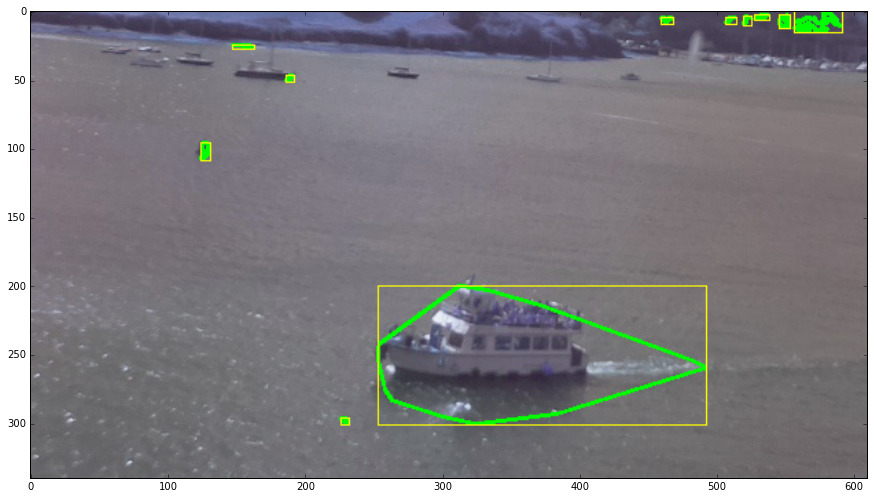

In [14]:
crawimage = cv2.imread(frawimage)
_ = cv2.drawContours(crawimage,unified,-1,(0,255,0),2)
for r in rectangles:
    _ = cv2.rectangle(crawimage, (r.top_left.x, r.top_left.y), (r.bottom_right.x, r.bottom_right.y), (255, 255,0))
plt.imshow(crawimage)

Each bounding rectangle represents a potention boat/ship (Let's not get into the technical difference between ships and boats...). The rectangles are extracts as separate images and placed into a list. There are 11 potential ships, the images of which are displayed.

In [15]:
ships=[]

crawimage = cv2.imread(frawimage)

for idx, r in enumerate(rectangles):
    roi = crawimage[r.top_left.y:r.bottom_right.y, r.top_left.x:r.bottom_right.x]
    ships.append(roi)
print("Number ship candidates:", len(ships))

Number ship candidates: 11


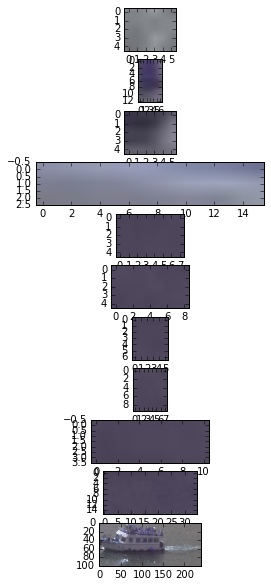

In [16]:
fig=plt.figure(figsize = (10, 10))
for i, img in enumerate(ships):
    a=fig.add_subplot(len(ships), 1, i+1)
    plt.imshow(img)

Now the TensorFlow DNN (a convolutional neural network) is loaded, and the images classified using the model. During the construction of the DNN the images are normalized, and this is done before classify the candidiate images

In [17]:
dnnmodel = 'C:/Boats/isaboat.ckpt'
dnnmetamodel = 'C:/Boats/isaboat.ckpt.meta'
std_image_size_x = 80
std_image_size_y = 20

In [18]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()

In [19]:
dnnmodel = 'C:/Boats/isaboat.ckpt'
dnnmetamodel = 'C:/Boats/isaboat.ckpt.meta'
reset_graph()

In [20]:
init = tf.global_variables_initializer()
saver = tf.train.import_meta_graph(dnnmetamodel)

In [21]:
def normalizeimage(img):
    img = cv2.resize(img, (std_image_size_x, std_image_size_y)) 
    norm_image = np.zeros((std_image_size_x, std_image_size_y))
    norm_image = cv2.normalize(img,  norm_image, 0, 255, cv2.NORM_MINMAX)
    norm_image = norm_image.flatten()
    return norm_image

In [22]:
Xclasslist = []
Yclasslist = []

for img in ships:
    norm_image = normalizeimage(img)
    Xclasslist.append(norm_image)
Xclassd = np.array(Xclasslist, dtype=np.float32)

In [23]:
validships = []
with tf.Session() as sess:
    saver.restore(sess,dnnmodel)
    # predict those to be classified
    graph = tf.get_default_graph()
    logits = graph.get_tensor_by_name('output/output/BiasAdd:0')
    Z = logits.eval(feed_dict={'inputs/X:0': Xclassd})
    y_pred = np.argmax(Z, axis=1)
    for i, cl in enumerate(y_pred):
        #print("Prediction:", i, cl)
        if cl == 1:
            validships.append(i)
print(validships)

INFO:tensorflow:Restoring parameters from C:/Boats/isaboat.ckpt
[10]


The Z array shows the classification of each of the 11 images. There are two float values for each image, a "No" value and a "Yes" value. The large value represents the most probable classification. In this case only one (the last) is identified as a boat. The y_pred array shows the image classification with "0" for not a boat and "1" for is a boat.

In [24]:
Z, y_pred

(array([[  6.27466297,   2.84358573],
        [  8.96985245,   7.7527523 ],
        [  3.74386287,  -0.30871505],
        [  2.15885067,  -1.33151364],
        [ 32.89021683,  12.97285461],
        [ 27.1992588 ,   9.3494482 ],
        [ 32.4765892 ,  12.95032692],
        [ 31.00510788,  11.42873478],
        [ 29.46682358,  11.61330223],
        [ 30.43778992,  12.8697176 ],
        [ -3.85837722,  -2.14032888]], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64))

Finally, display the image detected as a boat

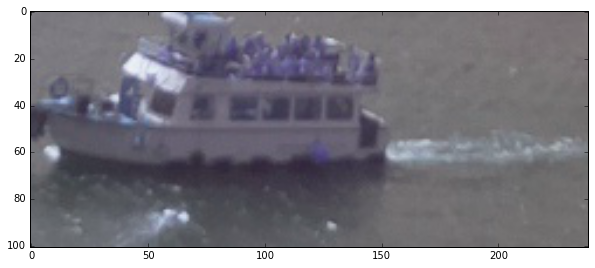

In [25]:
fig=plt.figure(figsize = (10, 10))
for i, indx in enumerate(validships):
    a=fig.add_subplot(len(validships), 1, i+1)
    img=ships[indx]
    plt.imshow(img)